# Samasource decision analysis

## Parameters:

* $Q$: quality threshold for SLA

* $N$: size of the dataset

* $R$: price for selling a labeled item in the dataset with quality above $Q$

* $C$: cost of labeling an item in the dataset

* $M$: cost of inspecting/monitoring the quality of an item, by a trusted expert

* $P$: penalty for not meeting the SLA


## Status variables:

* $n$: Size of the currently labeled dataset

* $m$: size of the currently inspected/monitoring dataset

* $s$: number of monitoring successes

* $p(s, m, Q)$: estimated probability that dataset has quality above $Q$, given $s$ and $m$



## Estimating dataset quality 

For estimating $p(s, m, Q)$, we use the Bayesian estimation of the success parameter for the binomial distribution. 

Under this modeling approach, the distribution of lot quality follows a Beta distribution, with parameters defined  by $s$ and $m$. 

To estimate the probability that the dataset quality is above the SLA threshold $Q$, we can use the CDF of the Beta distribution. This retuns the the probability that the quality of the dataset is above $Q$, given the successes and total monitoring attempts.

In [1]:
# Import the CDF of Beta distribution
from scipy.special import btdtr


# The probability that the dataset exceeds the threshold quality level Q,
# given that we had s successes out of m monitoring attempts.
def p(success,total, Q):
    # We use the Jeffrey prior 
    prior = {"success" : 0.5, "fail": 0.5} 
    f = total-success + prior["fail"]
    s = success + prior["success"] 
    return 1-btdtr(s, f,  Q)

In [2]:
# Example
# If we have 9 successes out of 10 trials, what is the probability that
# the sample has a quality above the threshold of 90%?
def test():
    successes = 8
    total = 10
    threshold_Q = 0.9
    print p(successes, total, threshold_Q)
    
test()



0.142996736354


In [3]:
N = 10
R = 1.0
k = 0.5
P = k*R*N
M = 0.1

threshold_Q = 0.8

print "Success\tTrials\tSuccess%\tProb lot above SLA\tExpected Utility\t% of Max Utility"
for m in range(1,10):
    for s in range(0,m+1):
        max_utility = N*R
        ship_expected_utility = R * N * p(s,m,threshold_Q) - P * (1-p(s,m,threshold_Q)) - M*m
        print s, "\t", m, "\t", 100*s/m, "\t", p(s, m, threshold_Q), "\t", ship_expected_utility, "\t", 100*ship_expected_utility/max_utility

Success	Trials	Success%	Prob lot above SLA	Expected Utility	% of Max Utility
0 	1 	0 	0.0405193263538 	-4.49221010469 	-44.9221010469
1 	1 	100 	0.549815144248 	3.14722716372 	31.4722716372
0 	2 	0 	0.00656627182756 	-5.10150592259 	-51.0150592259
1 	2 	50 	0.142378489933 	-3.06432265101 	-30.6432265101
2 	2 	100 	0.685627362353 	5.08441043529 	50.8441043529
0 	3 	0 	0.00113378310336 	-5.28299325345 	-52.8299325345
1 	3 	33 	0.0337287154486 	-4.79406926827 	-47.9406926827
2 	3 	66 	0.251028264417 	-1.53457603375 	-15.3457603375
3 	3 	100 	0.77254718194 	6.2882077291 	62.882077291
0 	4 	0 	0.000202499322068 	-5.39696251017 	-53.9696251017
1 	4 	25 	0.0076527695724 	-5.28520845641 	-52.8520845641
2 	4 	50 	0.0771886252422 	-4.24217062137 	-42.4217062137
3 	4 	75 	0.355332047921 	-0.0700192811787 	-0.700192811787
4 	4 	100 	0.832149343943 	7.08224015914 	70.8224015914
0 	5 	0 	3.6937760949e-05 	-5.49944593359 	-54.9944593359
1 	5 	20 	0.00169255337213 	-5.47461169942 	-54.7461169942
2 	5 

## Current status

At any given point, we are at a status described by the variables $(n, s, m)$. This means that:

* We have labeled $n$ examples, and invested $n \cdot C$ for labeling the dataset. 

* We monitored $m$ examples, and invested $m \cdot M$ for inspecting the dataset.

We need to decide what is our best next action. We are trying to take the best actions, to maximize our _expected_ utility. We want to decide whether to:

* **Label**: Label another example, at cost $C$, and move to state $(n+1, s, m)$:

* **Monitor**: Inspect the quality of the sample. We spend $M$ to increase the size of the sample to $m+1$. With probability p=s/m we move to $(n,s+1,m+1)$, and with probability $1-s/m$ we move to $(n,s,m+1)$. (Only when $m<n$).
 
* **Ship** The annotation is complete, so we ship the dataset. With some probability we have quality above $Q$, and get paid $R\cdot N$ and with some probability we do not meet the SLA, and pay penalty P. Utility of this action: $U_{Ship}(N, s, m) = R \cdot N \cdot p(s, m) - P \cdot (1-p(s,m))$. (Only when $n=N$).

* **Reject**: Reject the sample. We do not get any benefit or cost (but we have paid for the cost of monitoring and labeling).




In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pygraphviz

# We use NetworkX to visualize the steps
import networkx as nx
import networkx.drawing 
import networkx.algorithms.dag
from IPython.display import Image

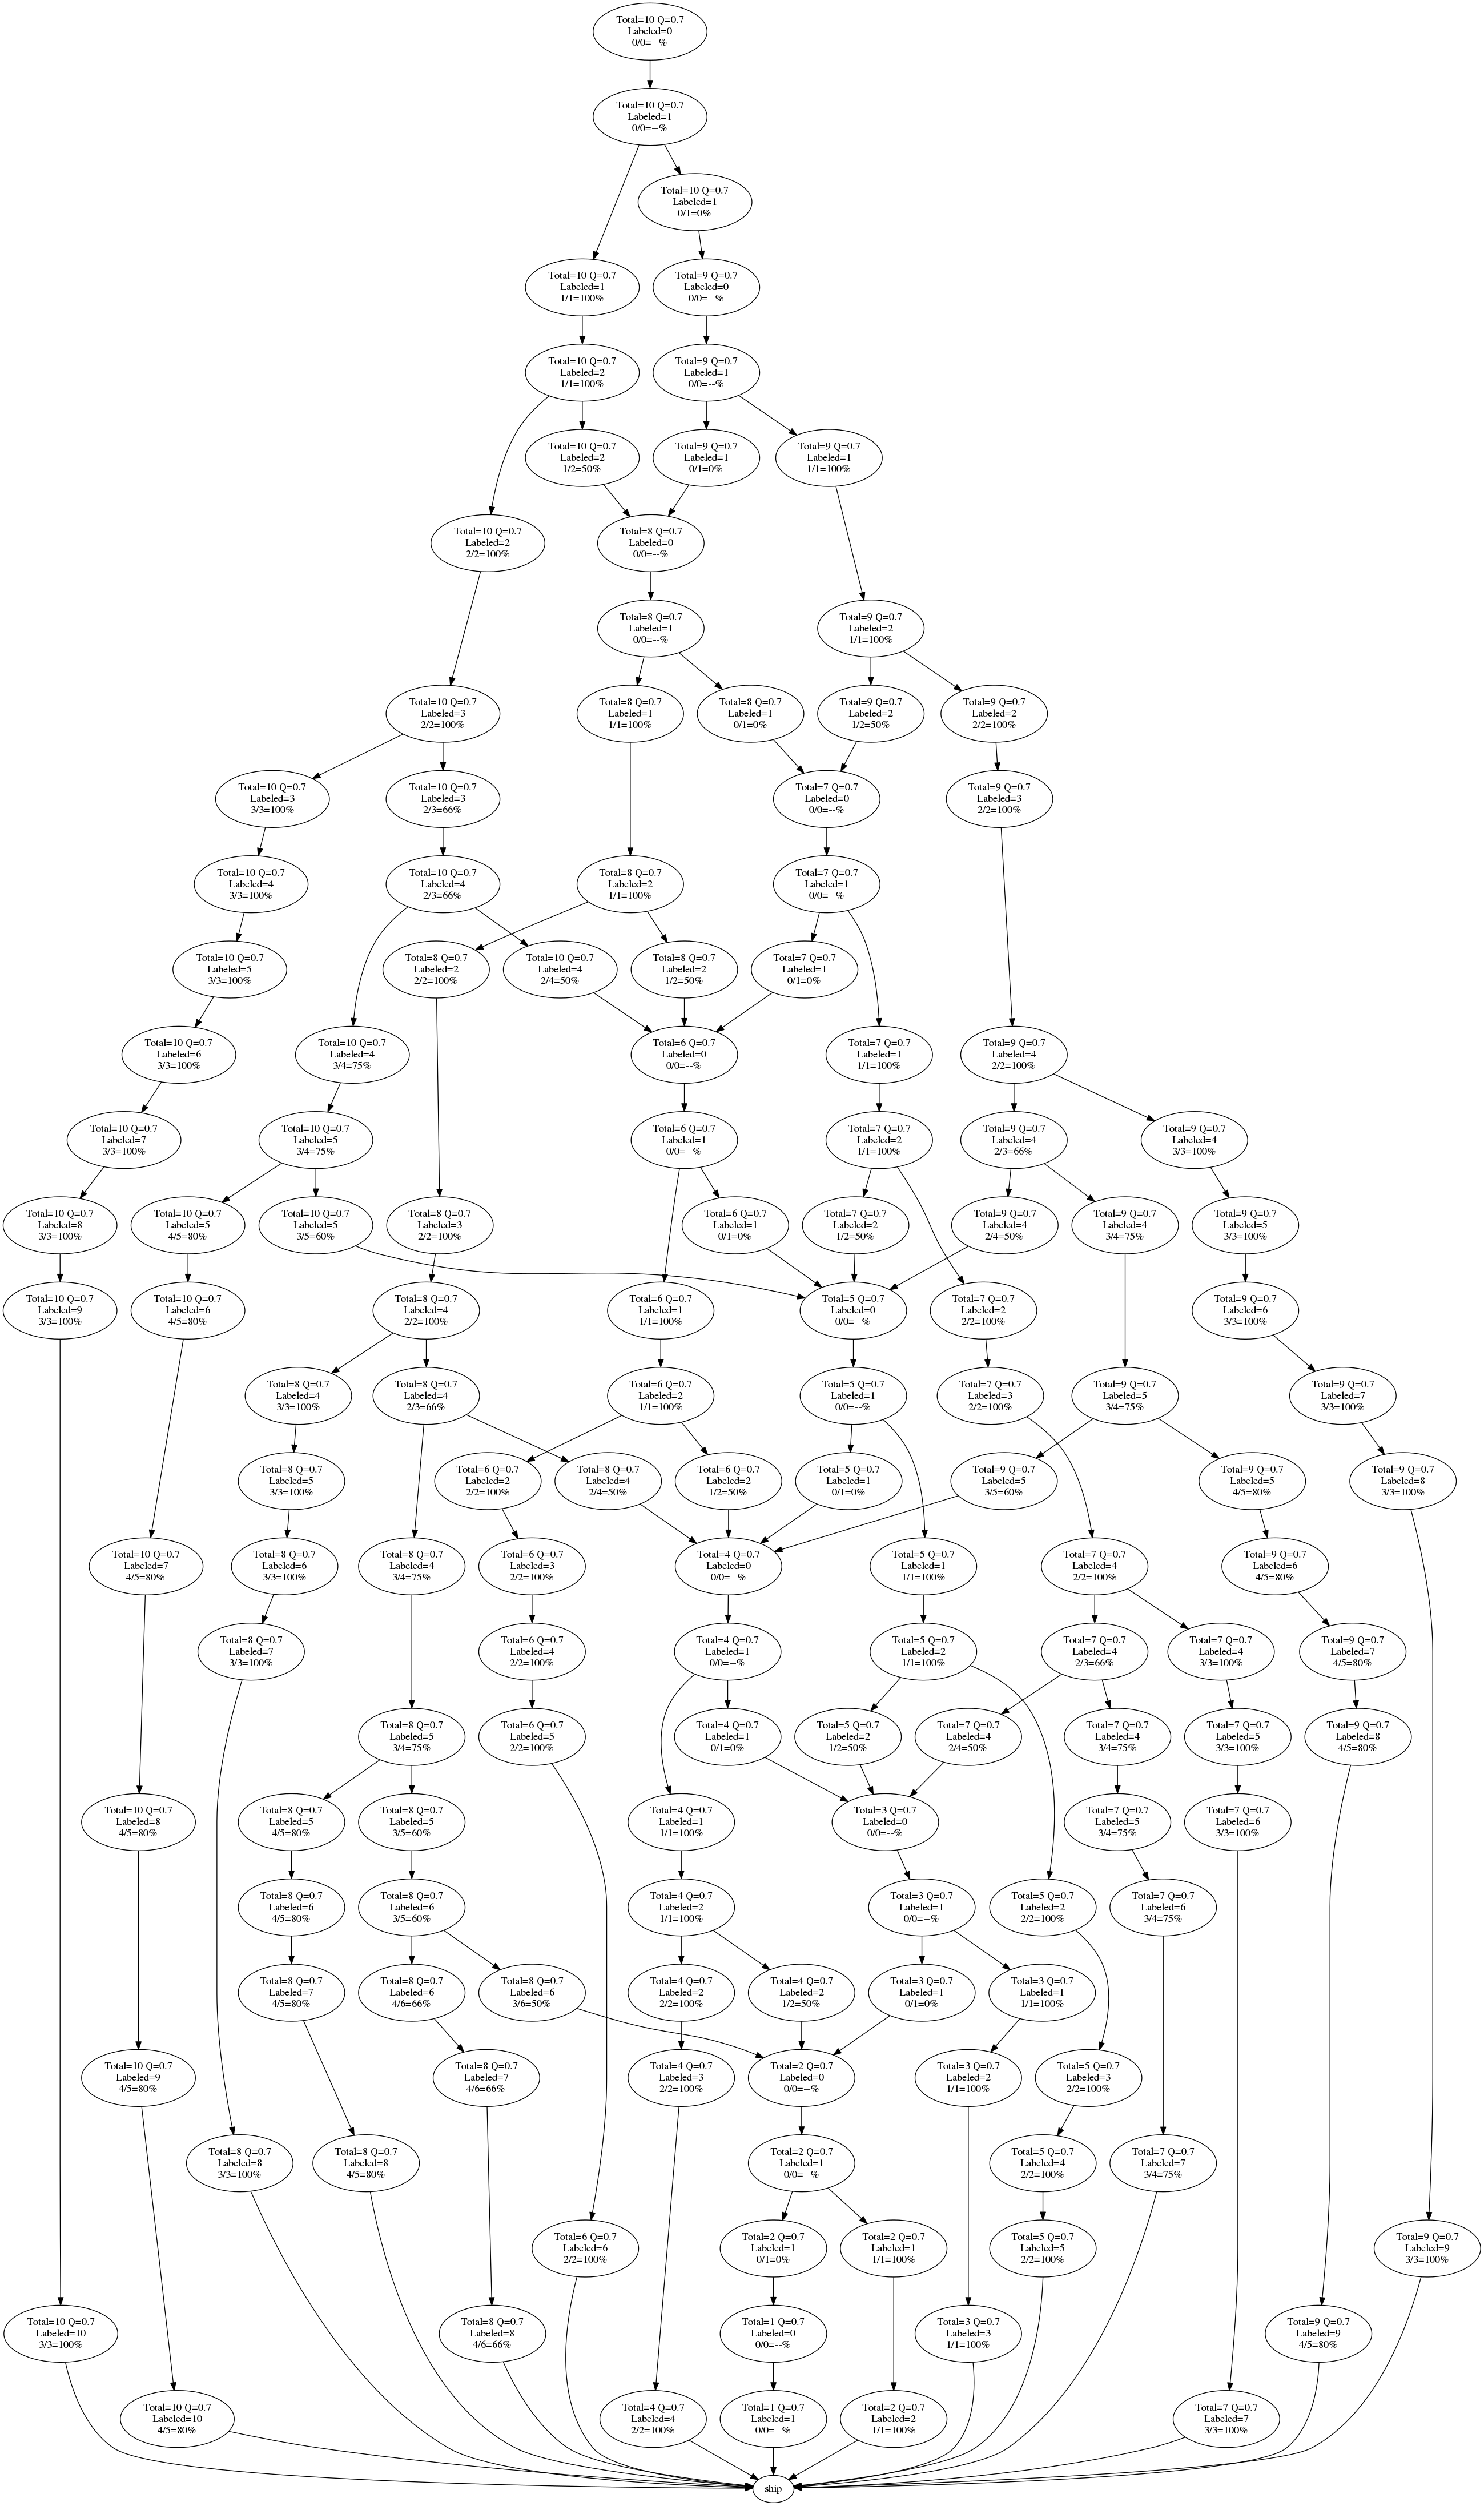

In [9]:



class Optimizer:

    # Initialization
    def __init__(self, R, C, M, Q, P):
        self.R = R
        self.C = C
        self.M = M
        self.Q = Q
        self.P = P
        self.cache = dict()

        self.G=nx.DiGraph()
        self.G.add_node("ship")
        self.G.add_node("reject")

    def getStatusKey(self,N,n,s,m,targetQ):
        if m>0:
            p = str(100*s/m)
        else:
            p = "--"
        return "Total=" + str(N) +" Q=" + str(targetQ) + "\nLabeled=" +str(n)+"\n"+str(s)+"/"+str(m)+ "=" + p + "%"


    # The function below implements a basic Markov Decision Process
    def optimizedUtility(self, N,n,s,m):

        best_utility = float("-inf");
        best_action = None
        key = self.getStatusKey(N,n,s,m,self.Q)

        # The caching is used to avoid re-computing the
        # actions/utilities of a state that we have already examined
        c = self.cache.get(key)
        if c is not None:
            return c


        # Compute the utility of shipping:
        # We only ship completed sets
        if (n==N):
            # We get rewarded R*N with probability p(s,m) and we 
            # get penalized P with probability 1-p(s,m)
            u_shipping = self.R * N * p(s,m,self.Q) - self.P * (1-p(s,m,self.Q)) # Terminal state
            if u_shipping > best_utility:
                best_action = "ship"
                best_utility = u_shipping


        # Compute the utility of labeling:
        # We incur the cost of labeling an extra example
        # for a cost of C and we move to the new state n+1, s, m
        if n < N:
            u_label = -self.C + self.optimizedUtility(N,n+1,s,m)
            if u_label>best_utility: 
                best_action = "label"
                best_utility = u_label

        # Compute the utility of monitoring:
        if m < n:
            # cost of monitoring
            u_monitor = -self.M 
            # we use a little bit of Laplacean smoothing here to avoid division by zero
            success_prob = (s+0.5)/(m+1)
            # unsuccessful monitoring
            u_monitor += (1 - success_prob) * self.optimizedUtility(N,n,s,m+1)
            # successful monitoring
            u_monitor += success_prob * self.optimizedUtility(N,n,s+1,m+1) 
            if u_monitor>best_utility: 
                best_action = "monitor"
                best_utility = u_monitor

        # Compute the utility of rejecting:
        # When we reject, we have already labeled correctly m examples out of N.
        # So we need to launch a new project and relabel the N-m remaining items
        # The new quality threshold is:  Qnew = (Q*N-m)/(N-m)
        # as the m examples have already quality 100% and overall we 
        # we want ((N-m)*Qnew + m * 1.0) / N > Q
        if m>0 and N>m:
            # Qnew = (self.Q*self.N - m) / (self.N-m)
            Qnew = self.Q
            if Qnew > 0:
                # o1 = Optimizer(self.N-m, self.R, self.C, self.M, Qnew, self.k)
                u_rejecting = self.optimizedUtility(N-m,0,0,0) # terminal state
                if u_rejecting > best_utility: 
                    best_action = "reject"
                    best_utility = u_rejecting

        self.cache[key] = best_utility

        # The code below is just for the visualization
        self.G.add_node(key)
        if best_action == "reject":
            key_reject = self.getStatusKey(N-m,0,0,0,Qnew)
            self.G.add_edge(key,key_reject)
        elif best_action == "ship":
            self.G.add_edge(key,"ship")
        elif best_action == "label":
            key_label =  self.getStatusKey(N,n+1,s,m,self.Q)
            self.G.add_edge(key,key_label)
        elif best_action == "monitor":
            key_monitor_fail = self.getStatusKey(N,n,s,m+1,self.Q)
            key_monitor_success = self.getStatusKey(N,n,s+1,m+1,self.Q)
            self.G.add_edge(key,key_monitor_success)
            self.G.add_edge(key,key_monitor_fail)  

        #print "Labeled\tSucc%\tSucc\tMonitor\tAction\tUtility"
        if m>0:
            pass
        #    print "%d\t%3.0f\t%2d\t%2d\t%s\t%6.3f" % (n, 100.0*s/m, s, m, best_action, best_utility)
        else:
            pass
        #    print "%d\t---\t%2d\t%2d\t%s\t%6.3f" % (n, s, m, best_action, best_utility)

        return best_utility

        
    def optimize(self, N, start_n, start_s, start_m):
        u = self.optimizedUtility(N, start_n, start_s, start_m)
        
        # Removes from the graph nodes not reachable from the root node "0-0-0"
        start_key = self.getStatusKey(N, start_n, start_s, start_m, self.Q)
        descendants = nx.descendants(self.G, start_key)

        nodes = self.G.nodes()
        for n in nodes:
            if n not in descendants and n != start_key:
                self.G.remove_node(n)
        
        A = nx.nx_agraph.to_agraph(self.G)
        A.layout('dot')
        A.draw('decision-plot.png')
        
        return u

def run():
    N = 10
    R = 1.0
    C = 0.01
    M = 0.1
    Q = 0.7
    k = 0.50 
    P = k*R*N # penalty is equal to a fraction of the total value of the contract
    o = Optimizer(R, C, M, Q, P)
    
    start_n = 0
    start_s = 0
    start_m = 0
    
    o.optimize(N, start_n, start_s, start_m)
    
    

    
run()
Image(filename='decision-plot.png') 

###### Things to notice

* Notice that, in some cases, we may decide to ship a sample even if the estimate of quality of the sample is below the target, especially if the penalty is low.

* The difference between binomial and hypergeometric shows when we have monitored almost every item in the dataset. Under binomial, we may still decide to ship a dataset with quality below the threshold. To understand that, you need to think of binomial as sampling with replacement, and hypergeometric as without replacement. In other words, in binomial, we assume that we may monitor "multiple times" the same item (and even get different results); clearly not the case in reality, but using the binomial approach makes for a much easier implementation of $p(s,m,Q)$.

* Try to see differences with difference parameter values for item price, item cost for labeling, item cost for monitoring, etc. 

* If there are settings where the decision feels strange, it is important to examine if there are business considerations that we have not included in the model.

* The model may decide to stop labeling early (i.e., "reject"), if there are too many monitored samples that are bad (e.g., see n=2, s=0, m=2).